# ANLP 2020 - Assignment 1


*Galina Ryazanskaya, 811155*

<div class="alert alert-block alert-danger">Due: Wednesday, December 2</div>

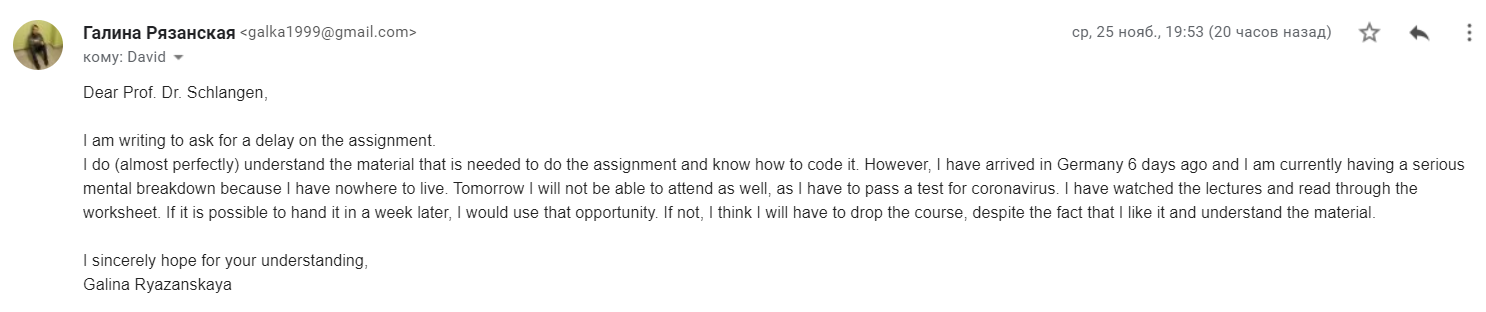

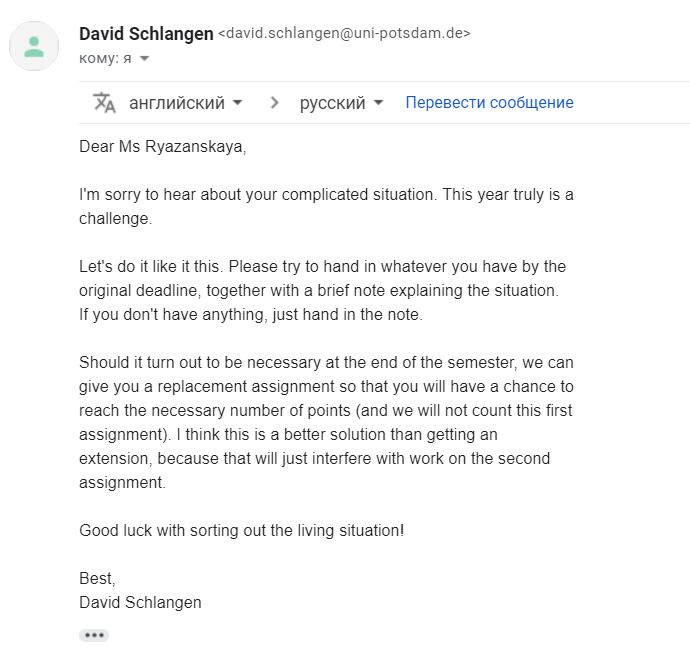

<div class="alert alert-block alert-info">

**NOTE**

Please first fill in your name and id number at the top of the assignment, and **rename** the assignment file to **yourlastname-anlp-1.ipynb**<br><br>
Problems and questions are given in blue boxes like this one. All grey and white boxes must be filled by you (they either require code or a (brief!) discussion). <br><br>
Please hand in your assignment by the deadline via Moodle upload. In case of questions, you can reach us via the piazza forum, or by email.<br><br>
<b>For this assignment, do NOT use any external packages (NLTK or any others) EXCEPT where specified.</b>
</div>

<div class="alert alert-block alert-info">
In this assignment, you will implement and work with a Naive Bayes classifier. (Note that for this exercise, you don't need to represent the input as a vector necessarily. You can directly look at the presence of words, and look up the class conditional likelihood.)
<br>
<br>
We will use a Twitter dataset classified into "hate speech" and "non hate speech" (in our data, we have called these classes "offensive" and "nonoffensive" to avoid the charged and inaccurate term "hate speech"). First, load the data (we have provided the function for this):
</div>

In [2]:
import csv
import json
from nltk.tokenize import TweetTokenizer

def read_hate_tweets (annofile, jsonfile):
    """Reads in hate speech data."""
    all_data = {}
    annos = {}
    with open(annofile) as csvfile:
        csvreader = csv.reader(csvfile, delimiter=',')
        for row in csvreader:
            if row[0] in annos:
                # if duplicate with different rating, remove!
                if row[1] != annos[row[0]]:
                    del(annos[row[0]])
            else:
                annos[row[0]] = row[1]

    tknzr = TweetTokenizer()
                
    with open(jsonfile) as jsonfile:
        for line in jsonfile:
            twtjson = json.loads(line)
            twt_id = twtjson['id_str']
            if twt_id in annos:
                all_data[twt_id] = {}
                all_data[twt_id]['offensive'] = "nonoffensive" if annos[twt_id] == 'none' else "offensive"
                all_data[twt_id]['text_tok'] = tknzr.tokenize(twtjson['text'])

    # split training and test data:
    all_data_sorted = sorted(all_data.items())
    items = [(i[1]['text_tok'],i[1]['offensive']) for i in all_data_sorted]
    splititem = len(all_data)-3250
    train_dt = items[:splititem]
    test_dt = items[splititem:]
    print('Training data:',len(train_dt))
    print('Test data:',len(test_dt))

    return(train_dt,test_dt)

TWEETS_ANNO = 'NAACL_SRW_2016.csv'
TWEETS_TEXT = 'NAACL_SRW_2016_tweets.json'

(train_data,test_data) = read_hate_tweets(TWEETS_ANNO,TWEETS_TEXT)


Training data: 12896
Test data: 3250


<div class="alert alert-block alert-info">
Each item in our data consists of a tuple of the tweet text and its label (represented as a string). The tweet text has been tokenized and is represented as a list of words. We can look at an example item:
</div>

In [2]:
print(train_data[4387])

(['At', 'this', 'rate', ',', "I'm", 'going', 'to', 'be', 'making', 'slides', 'for', 'a', 'keynote', 'in', 'my', 'car', 'as', 'I', 'drive', 'home', '.'], 'nonoffensive')


In [3]:
print(test_data[2])

(['This', 'is', 'why', 'this', 'show', 'is', 'ridiculous', '-', "it's", 'not', 'about', 'the', 'cooking', '...', "it's", 'about', 'the', 'game', 'playing', '.', '#mkr', '#whogivesa1'], 'nonoffensive')


## Problem 1: Evaluation [15 pts]

<div class="alert alert-block alert-info">

The first thing you're being asked to do is to provide evaluation functions for a classifier and a given labelled test set. Assume that the classifier has a `predict()` function that takes an item in the form of a list as above and predicts a class for that item. Write evaluation functions to compute the `accuracy` and `f_1` score for such a classifier. (To test your functions without having access to a real `predict()` function, you could simulate one that makes random predictions.)

</div>

In [3]:
def accuracy(classifier, data):
    """Computes the accuracy of a classifier on reference data.

    Args:
        classifier: A classifier.
        data: Reference data.

    Returns:
        The accuracy of the classifier on the test data, a float.
    """
    predicted = [classifier.predict(d) for d in [el[0] for el in data]]
    golden = [el[1] for el in data]
    TP_TN = 0
    for i, y in enumerate(golden):
        for j, y_hat in enumerate(predicted):
            if i == j:
                if y == y_hat:
                    TP_TN += 1
    return TP_TN / len(data)

def f_1(classifier, data, positive='offensive'):
    """Computes the F_1-score of a classifier on reference data.

    Args:
        classifier: A classifier.
        data: Reference data.
        positive: Positive class (str), default = 'offensive'

    Returns:
        The F_1-score of the classifier on the test data, a float.
    """
    predicted = [classifier.predict(d) for d in [el[0] for el in data]]
    golden = [el[1] for el in data]
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    for i, y in enumerate(golden):
        for j, y_hat in enumerate(predicted):
            if i == j:
                if y == positive:
                    if y == y_hat:
                        TP += 1
                    else:
                        FN += 1
                else:
                    if y == y_hat:
                        TN += 1
                    else:
                        FP += 1
    
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    return 2 * precision * recall / (precision + recall)


In [114]:
class dummy_classifier:
    def predict(self, data):
        return 'offensive'
c = dummy_classifier()
d = train_data[:5]

In [123]:
accuracy(c, d)

0.4

In [124]:
f_1(c, d)

0.5714285714285715

## Problem 2: Naive Bayes Classifier [35 pts]

<div class="alert alert-block alert-info">
Next, implement the Naive Bayes classifier from scratch using the code skeleton below and the definitions from class.<br><br>

Some requirements and notes for implementation:

<ul>
<li> You should allow for an arbitrary number of classes (in particular, you should not hard code the two classes needed for the given dataset). 
<li> The vocabulary of your classifier should be created dynamically from the training data. (The vocabulary is the set of all words that occur in the training data.).
<li> Use additive smoothing with a provided parameter k. 
<li> You may encounter unknown words at test time. Since we're not allowed to "peek" into the test set, we will implement the following simple treatment: We will assume that we don't know anything about unknown words and that in particular, their presence does not tell us anything about which class a document should be assigned to. Therefore, we will not include them in the calculation of the (log) probabilities during prediction, under the assumption that their probability does not differ hugely between the different classes (probably not a correct assumption, but the best we can do at this point). Since we don't need correct probabilities but only most likely classes, just ignore unknown words during prediction.
<li> Use log probabilities in order to avoid underflow.
</ul>

</div>

In [4]:
import matplotlib.pyplot as plt

from math import log
from time import time

In [102]:
class NaiveBayes(object):
    
    def __init__(self, data, k):
        """Initialises a new classifier."""
        self.k = k
        self.data = data
        self.x, self.y = [list(x) for x in zip(*data)]
        self.classes = list(set(self.y))
        self.N_doc = len(self.x) 
        self.N_classes = len(self.y)
        self.logpriors = {}  # keys - classes; values - logpriors
        self.loglike = {}  # keys - classes; values - dicts of words and loglikes
        self.D = []
        for d in self.x:
            self.D += d
        self.V = set(self.D) # vocabulary 


    def predict(self, x):
        """Predicts the class for a document.

        Args:
            x: A document, represented as a list of words.

        Returns:
            The predicted class, represented as a string.
        """
        probs = {}
        for c in self.classes:
            probs[c] = self.logpriors[c]           
            for w in x:
                if w in self.V:
                    probs[c] += self.loglike[c][w]
        
        return max(probs, key=probs.get)  # argmax over a dict
    
    
    @classmethod
    def train(cls, data, k=1):
        """Train a new classifier on training data using maximum
        likelihood estimation and additive smoothing.

        Args:
            cls: The Python class representing the classifier.
            data: Training data.
            k: The smoothing constant.

        Returns:
            A trained classifier, an instance of `cls`.
        """
        classifier = cls(data, k)
        
        for c in classifier.classes:  # iterate over classes
            n_c_documents = classifier.y.count(c)
            classifier.logpriors[c] = log(n_c_documents/classifier.N_classes)
            bigdoc = []
            for i, d in enumerate(classifier.x):
                if classifier.y[i] == c:
                    bigdoc += d
            
            classifier.loglike[c] = {}
            for w in classifier.V:  # iterate over words 
                count_w = bigdoc.count(w)
                classifier.loglike[c][w] = log((count_w + k) / (len(bigdoc) + len(classifier.V) * k))
                
        return classifier

<div class="alert alert-block alert-info">
Evaluate your classifier by training and testing it on the given data. Vary the smoothing parameter k. What happens when you decrease k? Plot a graph of the accuracy and/or f-score given different values of k. Discuss your findings.</div>

In [133]:
start = time()
nb = NaiveBayes.train(train_data)
print("Accuracy: ", accuracy(nb, test_data))
print("F_1: ", f_1(nb,test_data))

print(time() - start)  # how many seconds it took
# TODO: test further smoothing parameters

Accuracy:  0.8572307692307692
F_1:  0.5156576200417536
148.084552526474


2
1
0.5
0.1
0.01
0.001
15.012116463979085


Text(0, 0.5, 'accuracy (red), f1-score (blue)')

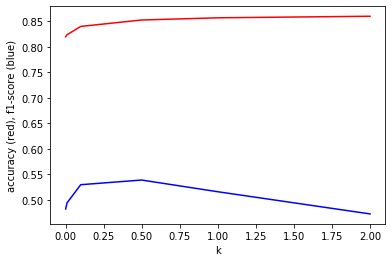

In [132]:
ks = [2, 1, 0.5, 0.1, 0.01, 0.001]
accs = []
f_1s = []

start = time()
for k in ks:
    print(k)
    nb = NaiveBayes.train(train_data, k=k)
    accs.append(accuracy(nb, test_data))
    f_1s.append(f_1(nb,test_data))
    
print((time() - start) / 60) # how much time the code took in minutes

plt.plot(ks, accs, 'r', ks, f_1s, 'b');
plt.xlabel('k')
plt.ylabel('accuracy (red), f1-score (blue)')

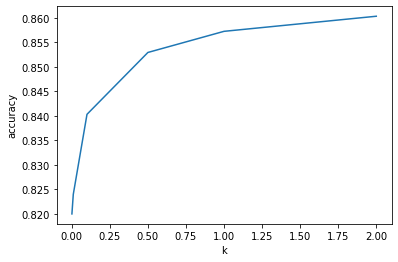

In [138]:
plt.plot(ks, accs);
plt.xlabel('k')
plt.ylabel('accuracy');

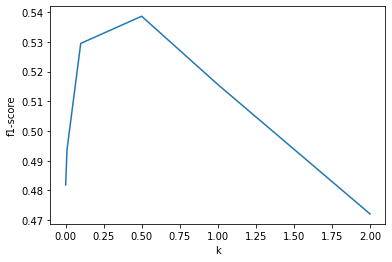

In [137]:
plt.plot(ks, f_1s)
plt.xlabel('k')
plt.ylabel('f1-score');

For accuracy, lowering the k-smoothing parameter does not seem to improve the results, as the highest accuracy is achieved at k=2. However, for the f1-score, the optimal smoothing seems to be below 1, but above 0.1. 

So, for both measures, some smoothing is beneficial for prediction, but as the corpus is quite small, the smoothing parameter should not be too high, so that it does not overshadow real low-frequency counts.

## Problem 3: Feature Engineering [20 pts]

<div class="alert alert-block alert-info">

We mentioned that the Naive Bayes classifier can be used with many different feature types. Try to improve on the basic bag of words model by changing the feature list of your model. Implement at least two variants. For each, explain your motivation for this feature set, and test the classifier with the given data. Briefly discuss your results!<br><br> 
Ideas for feature sets that were mentioned in class include:

<ul>
<li> removing stop words or frequent words
<li> stemming or lemmatizing (you can use NLTK or spacy.io for basic NLP operations on the texts)
<li> introducing part of speech tags as features (how?)
<li> bigrams
</ul>

</div>

### 1. removing stopwords

In [140]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

filter_stopwords = lambda text: [w for w in text if not w in stop_words]  

sw_train = [(filter_stopwords(text), label) for text, label in train_data]
sw_test = [(filter_stopwords(text), label) for text, label in test_data]

In [142]:
nb = NaiveBayes.train(sw_train)
print("Accuracy: ", accuracy(nb, sw_test))
print("F_1: ", f_1(nb, sw_test))

Accuracy:  0.8606153846153846
F_1:  0.5305699481865285


As one can see, there was only a very slight improvement from removing the stopwords (accuracy went from 0.857 to 0.860, and f1-score from 0.515 to 0.530). This was noted in the textbook: removing stopwords does not greatly affect the classifiers of this type.

### 2. lemmatize

In [147]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer() 

lemmatize = lambda text: [lemmatizer.lemmatize(w) for w in text]

lm_train = [(lemmatize(text), label) for text, label in train_data]
lm_test = [(lemmatize(text), label) for text, label in test_data]

In [148]:
nb = NaiveBayes.train(lm_train)
print("Accuracy: ", accuracy(nb, lm_test))
print("F_1: ", f_1(nb, lm_test))

Accuracy:  0.8587692307692307
F_1:  0.522372528616025


Again, the improvements are minor (accuracy went from 0.857 to 0.858, and f1-score from 0.515 to 0.522). This, as well, is foreshadowed in the textbook. I was surprized, however, that lemmatization does less than removing the stopwords, as I had expected that combining different wordforms would do more than removing words. I guess, I am biased by my native languge, Russian, where inflection is very strong, and thus lemmatization does do a lot more than for English.

### 3. combine the approaches
As the stopwords are given in lemmas, it would make more sense to try to remove them from the lemmatized corpus, and that gives the best results one can ahieve with these simple techniques.

In [149]:
swlm_train = [(filter_stopwords(text), label) for text, label in lm_train]
swlm_test = [(filter_stopwords(text), label) for text, label in lm_test]

In [150]:
nb = NaiveBayes.train(swlm_train)
print("Accuracy: ", accuracy(nb, swlm_test))
print("F_1: ", f_1(nb, sw_test))

Accuracy:  0.8615384615384616
F_1:  0.5241090146750526


## Problem 4: Logistic Regression Classifier [30 pts]

<div class="alert alert-block alert-info">
    
Implement a logistic regression classifier using the definitions given in class and gradient descent. For this, you will have to use a matrix representation for your data to keep track of each feature's weights per class, which you can implement using the `numpy` package. <br><br> 
Start by implementing a function `featurize()` that converts the (training or testing) data into a matrix format. This function should return a pair of NumPy matrices 𝑿, 𝒀, where 𝑿 is an 𝑁 × 𝐹 matrix (𝑁: number of data instances, 𝐹: number of features), and where 𝒀 is an 𝑁 × 2 matrix whose rows have one of two forms:<br><br>
[1, 0] if the gold-standard annotation class for the corresponding tweet is ‘offensive’, or <br><br>
[0, 1] if the gold-standard class for the corresponding document is ‘nonoffensive’<br><br>
This kind of representation is known as a one-hot encoding. You can read the first vector as saying that ‘there is a 100% chance that the instance belongs to the “offensive” class and a 0% chance that it belongs to the “nonoffensive” class’, and similarly for the second vector. Note that these are the two extreme cases for the conditional probability distribution P(k|x) for class k and feature vector x.<br><br>
To implement the `featurize()` function, you will need to assign to each word in the training set a unique integer index which will identify that component of the feature vector which is 1 if the corresponding word is present in the document, and 0 otherwise. This index is built by the helper function `build_w2i()`.<br><br>
Your next task is to complete the implementation of the `LogReg` class. The methods `p()` and `predict()` yield the probability of a class given an item, and the best class for the item, respectively. They can be implemented using appropriate NumPy matrix operations and the provided `softmax()` function. Note that you should set up both methods to take a whole matrix of input vectors as input, not just a single vector.<br><br>
The training procedure is implemented in the (class) method `train()`, using iterative optimization. Typically, we shuffle the training data and split them into mini-batches (e.g, 100 items), then update the weights after each minibatch. This is done for `max_iter` number of iterations, or "epochs". Each epoch iterates over the training data set once.<br><br>
Implement the missing methods using l_2 regularization with parameter C=0.1

</div>

In [54]:
import numpy as np
from math import ceil

In [19]:
def build_w2i(data):
    """
    Assigns each word in the training set a unique integer index 
    
    :param data: list of tuples (list of words, offensiveness tag)
    :return w2i: dict {str: int}, {word: index}
    """
    corpus = []
    texts = [el[0] for el in data]
    for text in texts:
            corpus += text
    vocab = set(corpus)
    w2i = dict(zip(vocab, range(len(vocab))))
    return w2i

In [139]:
ex_w2i = build_w2i(train_data[:10])
ex_w2i

{'the': 0,
 'yeah': 1,
 'they': 2,
 '#TheVoiceAu': 3,
 'really': 4,
 'mine': 5,
 'this': 6,
 'comebacks': 7,
 'back': 8,
 'acting': 9,
 ':': 10,
 'chance': 11,
 'The': 12,
 'Johnny': 13,
 "It's": 14,
 'ESPN': 15,
 'think': 16,
 'sexist': 17,
 'not': 18,
 'place': 19,
 '@Marshall_SS': 20,
 'as': 21,
 'on': 22,
 '%': 23,
 'will': 24,
 'be': 25,
 'driller': 26,
 'but': 27,
 'a': 28,
 'no': 29,
 'good': 30,
 'some': 31,
 'females': 32,
 '@berkeley_eagle': 33,
 'there': 34,
 'show': 35,
 '.': 36,
 'practical': 37,
 '@HannahCamille20': 38,
 ',': 39,
 '@brian_day15': 40,
 '@jbromley29': 41,
 '#random': 42,
 'Just': 43,
 'big': 44,
 'more': 45,
 'girls': 46,
 'rock': 47,
 'swear': 48,
 'woman': 49,
 'monogamous': 50,
 'when': 51,
 'has': 52,
 '@Yandiisa_': 53,
 'need': 54,
 'knowledge': 55,
 'RT': 56,
 'football': 57,
 'for': 58,
 'keep': 59,
 'sung': 60,
 'girl': 61,
 'honestly': 62,
 ':D': 63,
 'stand': 64,
 'comes': 65,
 'like': 66,
 'song': 67,
 'Smash': 68,
 'women': 69,
 'work': 70,
 'is

In [143]:
def featurize(data, w2i=None):
    """
    Converts the data into a matrix format,
        if given word to index, uses the vocabulary to featurize the texts, 
            skipping all the unfamiliar words
    
    :param data: list of tuples (list of words, offensiveness tag)
    :param w2i: dict {str: int}, {word: index}, optional, default None
    :return X: np.array of shape (number of data instances, number of features)
    :return Y: np.array of shape (number of data instances, 2), 
                    [1, 0] if offensive, [0, 1] if nonoffensive (one-hot encoded)
    """
    if not w2i:
        w2i = build_w2i(data)
    texts, labels = [list(x) for x in zip(*data)]
    X = np.zeros((len(data), len(w2i)))
    for i, text in enumerate(texts):
        w_text = set(text)
        for w in w_text:
            if w in w2i:
                X[i][w2i[w]] = 1.0
    Y = np.array([[1.0, 0.0] if label == 'offensive' else [0.0, 1.0] for label in labels])
    return X, Y

In [132]:
featurize(train_data[:2])

(array([[1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1.,
         0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0.,
         1., 1., 1., 1., 1., 1.]]), array([[1., 0.],
        [0., 1.]]))

In [140]:
featurize(test_data[:2], ex_w2i)

(array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [147]:
class LogReg:
    
    def __init__(self, eta=0.01, num_iter=30, C=0.1):
        self.eta = eta
        self.num_iter = num_iter
        self.C = C
    
    
    def softmax(self, inputs):
        """
        Calculate the softmax for the given inputs (array)
        
        :param inputs: np.array of shape (number of data instances, number of classes)
        :return: np.array of shape (number of data instances, number of classes)
        """
        # expands so that the initial implementation accepts matricies, not only vectors
        sf = lambda y: np.exp(y) / float(sum(np.exp(y)))
        return np.apply_along_axis(sf, 1, inputs)  
    
    
    def train(self, X, Y):
        batch_size = ceil(X.shape[0] / self.num_iter)
        
        # weights initialization
        self.weights = np.zeros((X.shape[1], Y.shape[1]))
        self.bias = np.zeros((1, Y.shape[1]))
        
        for i in range(self.num_iter):
            # divide dataset into batches
            j = (i + 1) * batch_size
            if j < X.shape[0]: 
                batch_X = X[j - batch_size: j, ]
                batch_Y = Y[j - batch_size: j, ]
            else:
                batch_X = X[j - batch_size: , ]
                batch_Y = Y[j - batch_size: , ]
            
            
            # predict with weights and biases
            Y_hat = np.exp(self.p(batch_X))  # of shape (number of data instances, number of classes)
            
            # calculate gradient on the batch
            delta_w = - np.dot(batch_X.T, (Y_hat - batch_Y)) + 2 * self.C * self.weights 
                # of shape (number of features, number of classes)
            delta_b = - np.mean(Y_hat - batch_Y) + 2 * self.C * self.bias
                # of shape (number of classes)
            
            # update weights and bias
            self.weights = self.weights - self.eta * delta_w
            self.bias = self.bias - self.eta * delta_b
            
        return None
    
    
    def get_loss(self, X, Y):
        """
        Calculate cross-entropy loss
        
        :param X: np.array of shape (number of data instances, number of features)
        :param Y: np.array of shape (number of data instances, number of classes)
        :param C: float, regularization, optional, default = 0.1
        :return: float, loss
        """
        log_predict = self.p(batch_X)
        loss_x = np.sum(np.multiply(Y, log_predict), axis=1)
        reg = np.sum(self.C * (self.weights **2)) + np.sum(self.C * (self.bias **2))
        loss = - 1/X.shape[0] *  np.sum(loss_x + reg, axis=0)
        return loss
    
    
    def p(self, X): 
        """
        Predict class log probabilities for given data
        
        :param X: np.array of shape (number of data instances, number of features)
        :return: np.array of shape (number of data instances, number of classes),
                 log probabilities of each class 
        """
        return np.log(self.softmax(np.dot(X, self.weights) + self.bias))
    
    
    def predict(self, X):
        """
        Predict classes for given data
        
        :param X: np.array of shape (number of data instances, number of features)
        :return: float, class
        """
        probs = self.p(X)
        return np.argmax(probs, axis=1)

In [75]:
lg.softmax(np.array([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]]))

array([[0.09003057, 0.24472847, 0.66524096],
       [0.09003057, 0.24472847, 0.66524096]])

<div class="alert alert-block alert-info">
Test your implementation using 10 iterations, default learning rate eta, and l_2 regularization with parameter C=0.1.
</div>

In [149]:
lg = LogReg(num_iter = 10)
w2i = build_w2i(train_data)
X_train, Y_train = featurize(train_data)
X_test, Y_test = featurize(test_data, w2i)
lg.train(X_train, Y_train)

In [151]:
lg.predict(X_test[:10])

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [150]:
np.argmax(Y_test[:10], axis=1)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0], dtype=int64)

In [156]:
from sklearn.metrics import accuracy_score, f1_score
predicted = lg.predict(X_test)
true = np.argmax(Y_test, axis=1)

In [157]:
accuracy_score(predicted, true)

0.8123076923076923

In [159]:
f1_score(predicted, true)

0.8964346349745331